In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/uchicago/sociohydro/sim/meanField/SchellingMF`


In [2]:
using ModelingToolkit
using MethodOfLines
using OrdinaryDiffEq
using LinearSolve
using DomainSets
using Plots
using BenchmarkTools

# Sociohydrodyanmics

We have the following equations of motion (taking the limit where occupation fractions are much smaller than the carrying capacity, getting rid of $\phi$ dependencies in $D^{ab}$ and factors of $(1 - \phi^A - \phi^B)$)
$$
\begin{align}
\partial_t \phi^a(\mathbf{r}, t) &= - \nabla \cdot \mathbf{J}^a \left( \vec{\phi}(\mathbf{r}, t) \right) \\
\mathbf{J}^a \left( \vec{\phi}(\mathbf{r}, t) \right) &= -D_0 \nabla \phi^a + \phi^a \nabla \pi^a \left( \vec{\phi} \right) + \Gamma_0 \phi^a \nabla^3 \phi^a
\end{align}
$$
with some predefined set of utility functions $\pi^a(\vec{\phi})$. We will work on a domain $\mathbf{r} \in [0, L]^2$.

The initial conditions are $\phi^a(\mathbf{r}, 0)$ and we will work with the boundary conditions
$$
\begin{cases}
\nabla \phi^a = 0 & \text{no diffusive flux} \\
\mathbf{J}^a = 0 & \text{no flux}
\end{cases}
$$

Let's first try 1D

In [27]:
@parameters t x
# @parameters κaa κab κba κbb D0
@variables ϕA(..) ϕB(..)

κ = [0 0; 0 0];
D0 = 1
Γ = 1

x_min = t_min = 0.0
x_max = 10
t_max = 10

Dt = Differential(t)
Dx = Differential(x)
Dx² = Differential(x)^2
Dx³ = Differential(x)^3
Dx⁴ = Differential(x)^4

function fA(ϕ, κ)
    fitnessA = (κ * ϕ)[1]
    return fitnessA
end

function fB(ϕ, κ)
    fitnessB = (κ * ϕ)[2]
    return fitnessB
end

# function JA(ϕ, κ, D0, Γ)
#     return -D0 * Dx(ϕ[1]) + ϕ[1] * Dx(fA(ϕ, κ)) + Γ * ϕ[1] * Dx³(ϕ[1])
# end

# function JB(ϕ, κ, D0, Γ)
#     return -D0 * Dx(ϕ[2]) + ϕ[2] * Dx(fB(ϕ, κ)) + Γ * ϕ[2] * Dx³(ϕ[2])
# end

# JA(x, t) = -D0 * Dx(ϕA(x, t)) + ϕA(x, t) * Dx(fA([ϕA(x, t); ϕB(x, t)], κ)) + Γ * ϕA(x, t) * Dx³(ϕA(x, t))
# JB(x, t) = -D0 * Dx(ϕB(x, t)) + ϕB(x, t) * Dx(fB([ϕA(x, t); ϕB(x, t)], κ)) + Γ * ϕB(x, t) * Dx³(ϕB(x, t))

# 1D pde, domain, and bounary conditions
# eqs = [Dt(ϕA(x, t)) ~ -Dx(-D0 * Dx(ϕA(x, t)) + ϕA(x, t) * Dx(fA([ϕA(x, t); ϕB(x, t)], κ)) + Γ * ϕA(x, t) * Dx³(ϕA(x, t))),
       # Dt(ϕB(x, t)) ~ -Dx(-D0 * Dx(ϕB(x, t)) + ϕB(x, t) * Dx(fB([ϕA(x, t); ϕB(x, t)], κ)) + Γ * ϕB(x, t) * Dx³(ϕB(x, t)))]

eqs = [Dt(ϕA(x, t)) ~ D0 * Dx²(ϕA(x, t)) - Γ * Dx(ϕA(x, t) * Dx³(ϕA(x, t))),
       Dt(ϕB(x, t)) ~ D0 * Dx²(ϕB(x, t)) - Γ * Dx(ϕB(x, t) * Dx³(ϕB(x, t)))]


domains = [x ∈ Interval(x_min, x_max),
           t ∈ Interval(t_min, t_max)]

bcs = [ϕA(x, t_min) ~ 0.25 + 0.01 * sin(2π * x + 0.0 * π),
       ϕB(x, t_min) ~ 0.25 + 0.01 * sin(2π * x + 0.5 * π),
       Dx(ϕA(x_min, t)) ~ 0,
       Dx(ϕA(x_max, t)) ~ 0,
       Dx(ϕB(x_min, t)) ~ 0,
       Dx(ϕA(x_max, t)) ~ 0,
       D0 * Dx(ϕA(x_min, t)) - Γ * ϕA(x_min, t) * Dx³(ϕA(x_min, t)) ~ 0,
       D0 * Dx(ϕA(x_max, t)) - Γ * ϕA(x_max, t) * Dx³(ϕA(x_max, t)) ~ 0,
       D0 * Dx(ϕB(x_min, t)) - Γ * ϕB(x_min, t) * Dx³(ϕB(x_min, t)) ~ 0,
       D0 * Dx(ϕB(x_max, t)) - Γ * ϕB(x_max, t) * Dx³(ϕB(x_max, t)) ~ 0]

       # -D0 * Dx(ϕA(x_min, t)) + ϕA(x_min, t) * Dx(fA([ϕA(x_min, t); ϕB(x_min, t)], κ)) + Γ * ϕA(x_min, t) * Dx³(ϕA(x_min, t)) ~ 0,
       # -D0 * Dx(ϕA(x_max, t)) + ϕA(x_max, t) * Dx(fA([ϕA(x_max, t); ϕB(x_max, t)], κ)) + Γ * ϕA(x_max, t) * Dx³(ϕA(x_max, t)) ~ 0,
       # -D0 * Dx(ϕB(x_min, t)) + ϕB(x_min, t) * Dx(fB([ϕA(x_min, t); ϕB(x_min, t)], κ)) + Γ * ϕB(x_min, t) * Dx³(ϕB(x_min, t)) ~ 0,
       # -D0 * Dx(ϕB(x_max, t)) + ϕB(x_max, t) * Dx(fB([ϕA(x_max, t); ϕB(x_max, t)], κ)) + Γ * ϕB(x_max, t) * Dx³(ϕB(x_max, t)) ~ 0]

@named pdesys = PDESystem(eqs, bcs, domains, [x, t], [ϕA(x, t), ϕB(x, t)])

PDESystem
Equations: Equation[Differential(t)(ϕA(x, t)) ~ -Differential(x)(Differential(x)(Differential(x)(Differential(x)(ϕA(x, t))))*ϕA(x, t)) + Differential(x)(Differential(x)(ϕA(x, t))), Differential(t)(ϕB(x, t)) ~ -Differential(x)(Differential(x)(Differential(x)(Differential(x)(ϕB(x, t))))*ϕB(x, t)) + Differential(x)(Differential(x)(ϕB(x, t)))]
Boundary Conditions: Equation[ϕA(x, 0.0) ~ 0.25 + 0.01sin(6.283185307179586x), ϕB(x, 0.0) ~ 0.25 + 0.01sin(1.5707963267948966 + 6.283185307179586x), Differential(x)(ϕA(0.0, t)) ~ 0, Differential(x)(ϕA(10, t)) ~ 0, Differential(x)(ϕB(0.0, t)) ~ 0, Differential(x)(ϕA(10, t)) ~ 0, Differential(x)(ϕA(0.0, t)) - ϕA(0.0, t)*Differential(x)(Differential(x)(Differential(x)(ϕA(0.0, t)))) ~ 0, Differential(x)(ϕA(10, t)) - Differential(x)(Differential(x)(Differential(x)(ϕA(10, t))))*ϕA(10, t) ~ 0, Differential(x)(ϕB(0.0, t)) - Differential(x)(Differential(x)(Differential(x)(ϕB(0.0, t))))*ϕB(0.0, t) ~ 0, Differential(x)(ϕB(10, t)) - Differential(x)(Dif

In [28]:
bcs

10-element Vector{Equation}:
 ϕA(x, 0.0) ~ 0.25 + 0.01sin(6.283185307179586x)
 ϕB(x, 0.0) ~ 0.25 + 0.01sin(1.5707963267948966 + 6.283185307179586x)
 Differential(x)(ϕA(0.0, t)) ~ 0
 Differential(x)(ϕA(10, t)) ~ 0
 Differential(x)(ϕB(0.0, t)) ~ 0
 Differential(x)(ϕA(10, t)) ~ 0
 Differential(x)(ϕA(0.0, t)) - ϕA(0.0, t)*Differential(x)(Differential(x)(Differential(x)(ϕA(0.0, t)))) ~ 0
 Differential(x)(ϕA(10, t)) - Differential(x)(Differential(x)(Differential(x)(ϕA(10, t))))*ϕA(10, t) ~ 0
 Differential(x)(ϕB(0.0, t)) - Differential(x)(Differential(x)(Differential(x)(ϕB(0.0, t))))*ϕB(0.0, t) ~ 0
 Differential(x)(ϕB(10, t)) - Differential(x)(Differential(x)(Differential(x)(ϕB(10, t))))*ϕB(10, t) ~ 0

In [29]:
N = 32
order = 2
dx = (x_max - x_min) / N
# dy = (y_max - y_min) / N

discretization = MOLFiniteDifference([x => dx], t,
                                     approx_order = order,
                                     grid_align = center_align)

MOLFiniteDifference{MethodOfLines.CenterAlignedGrid, MethodOfLines.ScalarizedDiscretization}(Dict{Num, Float64}(x => 0.3125), t, 2, UpwindScheme(1), MethodOfLines.CenterAlignedGrid(), true, false, MethodOfLines.ScalarizedDiscretization(), true, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}())

In [30]:
prob = discretize(pdesys, discretization);

┌ Warning: Incompatible term found. Adding auxiliary equation ϕAˍxx(x, t) ~ Differential(x)(Differential(x)(ϕA(x, t))) to the system.
└ @ MethodOfLines ~/.julia/packages/MethodOfLines/8J3AD/src/system_parsing/pde_system_transformation.jl:218
┌ Warning: Incompatible term found. Adding auxiliary equation ϕBˍxx(x, t) ~ Differential(x)(Differential(x)(ϕB(x, t))) to the system.
└ @ MethodOfLines ~/.julia/packages/MethodOfLines/8J3AD/src/system_parsing/pde_system_transformation.jl:218


The system of equations is:
Equation[Differential(t)((ϕA(t))[3]) - (ϕAˍxx(t))[3] - 3.2(-0.0625(ϕA(t))[1] + 0.5625(ϕA(t))[2] + 0.5625(ϕA(t))[3] - 0.0625(ϕA(t))[4])*(-3.2(ϕAˍxx(t))[2] + 3.2(ϕAˍxx(t))[3]) + 3.2(-0.0625(ϕA(t))[2] + 0.5625(ϕA(t))[3] + 0.5625(ϕA(t))[4] - 0.0625(ϕA(t))[5])*(-3.2(ϕAˍxx(t))[3] + 3.2(ϕAˍxx(t))[4]) ~ 0, Differential(t)((ϕA(t))[4]) - (ϕAˍxx(t))[4] - 3.2(-0.0625(ϕA(t))[2] + 0.5625(ϕA(t))[3] + 0.5625(ϕA(t))[4] - 0.0625(ϕA(t))[5])*(-3.2(ϕAˍxx(t))[3] + 3.2(ϕAˍxx(t))[4]) + 3.2(-0.0625(ϕA(t))[3] + 0.5625(ϕA(t))[4] + 0.5625(ϕA(t))[5] - 0.0625(ϕA(t))[6])*(-3.2(ϕAˍxx(t))[4] + 3.2(ϕAˍxx(t))[5]) ~ 0, Differential(t)((ϕA(t))[5]) - (ϕAˍxx(t))[5] - 3.2(-0.0625(ϕA(t))[3] + 0.5625(ϕA(t))[4] + 0.5625(ϕA(t))[5] - 0.0625(ϕA(t))[6])*(-3.2(ϕAˍxx(t))[4] + 3.2(ϕAˍxx(t))[5]) + 3.2(-0.0625(ϕA(t))[4] + 0.5625(ϕA(t))[5] + 0.5625(ϕA(t))[6] - 0.0625(ϕA(t))[7])*(-3.2(ϕAˍxx(t))[5] + 3.2(ϕAˍxx(t))[6]) ~ 0, Differential(t)((ϕA(t))[6]) - (ϕAˍxx(t))[6] - 3.2(-0.0625(ϕA(t))[4] + 0.5625(ϕA(t))[5] + 0

LoadError: ExtraVariablesSystemException: The system is unbalanced. There are 132 highest order derivative variables and 131 equations.
More variables than equations, here are the potential extra variable(s):
 (ϕA(t))[3]
 (ϕA(t))[4]
 (ϕA(t))[5]
 (ϕA(t))[6]
 (ϕA(t))[7]
 (ϕA(t))[8]
 (ϕA(t))[9]
 (ϕA(t))[10]
 (ϕA(t))[11]
 (ϕA(t))[12]
 (ϕA(t))[13]
 (ϕA(t))[14]
 (ϕA(t))[15]
 (ϕA(t))[16]
 (ϕA(t))[17]
 (ϕA(t))[18]
 (ϕA(t))[19]
 (ϕA(t))[20]
 (ϕA(t))[21]
 (ϕA(t))[22]
 (ϕA(t))[23]
 (ϕA(t))[24]
 (ϕA(t))[25]
 (ϕA(t))[26]
 (ϕA(t))[27]
 (ϕA(t))[28]
 (ϕA(t))[29]
 (ϕA(t))[30]
 (ϕB(t))[3]
 (ϕB(t))[4]
 (ϕB(t))[5]
 (ϕB(t))[6]
 (ϕB(t))[7]
 (ϕB(t))[8]
 (ϕB(t))[9]
 (ϕB(t))[10]
 (ϕB(t))[11]
 (ϕB(t))[12]
 (ϕB(t))[13]
 (ϕB(t))[14]
 (ϕB(t))[15]
 (ϕB(t))[16]
 (ϕB(t))[17]
 (ϕB(t))[18]
 (ϕB(t))[19]
 (ϕB(t))[20]
 (ϕB(t))[21]
 (ϕB(t))[22]
 (ϕB(t))[23]
 (ϕB(t))[24]
 (ϕB(t))[25]
 (ϕB(t))[26]
 (ϕB(t))[27]
 (ϕB(t))[28]
 (ϕB(t))[29]
 (ϕB(t))[30]
 (ϕB(t))[31]
 (ϕB(t))[32]
 (ϕAˍxx(t))[32]

# cahn-hilliard

In [8]:
@parameters t x y
# @parameters κaa κab κba κbb D0
@variables ϕ(..) Jx(..) Jy(..)

x_min = y_min = t_min = 0.0
x_max = y_max = 10
t_max = 10

Dt = Differential(t)
Dx = Differential(x)
Dy = Differential(y)
Dx² = Differential(x)^2
Dy² = Differential(y)^2
∇²(u) = Dx²(u) + Dy²(u)
ϕ0 = 0.01 * sin(2π * x / (x_max/2)) * cos(2π * y / (y_max/2))


# 1D pde, domain, and bounary conditions
eqs = [∂x∇²ϕ(x, y, t) ~ Dx(∇²(ϕ(x, y, t))),
       ∂y∇²ϕ(x, y, t) ~ Dy(∇²(ϕ(x, y, t))),
       Jx(x, y, t) ~ -Dx(-ϕ(x, y, t) + ϕ(x, y, t)^3) - ∂x∇²ϕ(x, y, t),
       Jy(x, y, t) ~ -Dy(-ϕ(x, y, t) + ϕ(x, y, t)^3) - Dyyyϕ(x, y, t),
       Dt(ϕ(x, y, t)) ~ -(Dx(Jx(x, y, t)) + Dy(Jy(x, y, t))),]

domains = [x ∈ Interval(x_min, x_max),
           y ∈ Interval(y_min, y_max),
           t ∈ Interval(t_min, t_max)]

bcs = [ϕ(x, y, t_min) ~ ϕ0,
       Dx(ϕ(x_min, y, t)) ~ 0,
       Dx(ϕ(x_max, y, t)) ~ 0,
       Dy(ϕ(x, y_min, t)) ~ 0,
       Dy(ϕ(x, y_max, t)) ~ 0,
       Jx(x_min, y, t) ~ 0,
       Jx(x_max, y, t) ~ 0,
       Jy(x, y_min, t) ~ 0,
       Jy(x, y_max, t) ~ 0]

@named pdesys = PDESystem(eqs, bcs, domains, [x, y, t], [ϕ(x, y, t), Jx(x, y, t), Jy(x, y, t), ∂x∇²ϕ(x, y, t), ∂y∇²ϕ(x, y, t)])

PDESystem
Equations: Equation[∂x∇²ϕ(x, y, t) ~ Differential(x)(Differential(x)(Differential(x)(ϕ(x, y, t))) + Differential(y)(Differential(y)(ϕ(x, y, t)))), ∂y∇²ϕ(x, y, t) ~ Differential(y)(Differential(x)(Differential(x)(ϕ(x, y, t))) + Differential(y)(Differential(y)(ϕ(x, y, t)))), Jx(x, y, t) ~ -∂x∇²ϕ(x, y, t) - Differential(x)(-ϕ(x, y, t) + ϕ(x, y, t)^3), Jy(x, y, t) ~ -Dyyyϕ(x, y, t) - Differential(y)(-ϕ(x, y, t) + ϕ(x, y, t)^3), Differential(t)(ϕ(x, y, t)) ~ -Differential(y)(Jy(x, y, t)) - Differential(x)(Jx(x, y, t))]
Boundary Conditions: Equation[ϕ(x, y, 0.0) ~ 0.01cos(1.2566370614359172y)*sin(1.2566370614359172x), Differential(x)(ϕ(0.0, y, t)) ~ 0, Differential(x)(ϕ(10, y, t)) ~ 0, Differential(y)(ϕ(x, 0.0, t)) ~ 0, Differential(y)(ϕ(x, 10, t)) ~ 0, Jx(0.0, y, t) ~ 0, Jx(10, y, t) ~ 0, Jy(x, 0.0, t) ~ 0, Jy(x, 10, t) ~ 0]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(x, 0.0 .. 10.0), Symbolics.VarDomainPairing(y, 0.0 .. 10.0), Symbolics.VarDomainPairing(t, 0.0 .

In [13]:
N = 6
order = 2
dx = (x_max - x_min) / N
dy = (y_max - y_min) / N

discretization = MOLFiniteDifference([x => dx, y => dy], t,
                                     approx_order = order,
                                     grid_align = center_align)

MOLFiniteDifference{MethodOfLines.CenterAlignedGrid, MethodOfLines.ScalarizedDiscretization}(Dict{Num, Float64}(y => 1.6666666666666667, x => 1.6666666666666667), t, 2, UpwindScheme(1), MethodOfLines.CenterAlignedGrid(), true, false, MethodOfLines.ScalarizedDiscretization(), true, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}())

In [14]:
prob = discretize(pdesys, discretization);

┌ Warning: Incompatible term found. Adding auxiliary equation var"⟦Differential(x)(Differential(x)(ϕ(x, y, t))) + Differential(y)(Differential(y)(ϕ(x, y, t)))⟧"(x, y, t) ~ Differential(x)(Differential(x)(ϕ(x, y, t))) + Differential(y)(Differential(y)(ϕ(x, y, t))) to the system.
└ @ MethodOfLines ~/.julia/packages/MethodOfLines/8J3AD/src/system_parsing/pde_system_transformation.jl:218
┌ Warning: Incompatible term found. Adding auxiliary equation var"⟦-ϕ(x, y, t) + ϕ(x, y, t)^3⟧"(x, y, t) ~ -ϕ(x, y, t) + ϕ(x, y, t)^3 to the system.
└ @ MethodOfLines ~/.julia/packages/MethodOfLines/8J3AD/src/system_parsing/pde_system_transformation.jl:218


The system of equations is:
Equation[0.6(var"var\"⟦Differential(x)(Differential(x)(ϕ(x, y, t))) + Differential(y)(Differential(y)(ϕ(x, y, t)))⟧\""(t))[1, 1] - 0.6(var"var\"⟦Differential(x)(Differential(x)(ϕ(x, y, t))) + Differential(y)(Differential(y)(ϕ(x, y, t)))⟧\""(t))[2, 1] + (∂x∇²ϕ(t))[1, 1] ~ 0, 0.6(var"var\"⟦Differential(x)(Differential(x)(ϕ(x, y, t))) + Differential(y)(Differential(y)(ϕ(x, y, t)))⟧\""(t))[2, 1] - 0.6(var"var\"⟦Differential(x)(Differential(x)(ϕ(x, y, t))) + Differential(y)(Differential(y)(ϕ(x, y, t)))⟧\""(t))[3, 1] + (∂x∇²ϕ(t))[2, 1] ~ 0, 0.6(var"var\"⟦Differential(x)(Differential(x)(ϕ(x, y, t))) + Differential(y)(Differential(y)(ϕ(x, y, t)))⟧\""(t))[3, 1] - 0.6(var"var\"⟦Differential(x)(Differential(x)(ϕ(x, y, t))) + Differential(y)(Differential(y)(ϕ(x, y, t)))⟧\""(t))[4, 1] + (∂x∇²ϕ(t))[3, 1] ~ 0, 0.6(var"var\"⟦Differential(x)(Differential(x)(ϕ(x, y, t))) + Differential(y)(Differential(y)(ϕ(x, y, t)))⟧\""(t))[4, 1] - 0.6(var"var\"⟦Differential(x)(Differential(

LoadError: ArgumentError: Differential w.r.t. multiple variables Any[0.0, 10.0, t] are not allowed.

In [103]:
sol = solve(prob, TRBDF2(), saveat=0.1);

In [104]:
discrete_x = sol[x];
discrete_y = sol[y];
discrete_t = sol[t];
sol_ϕ = sol[ϕ(x, y, t)];

[ Info: Saved animation to /Users/danny/code/uchicago/sociohydro/sim/meanField/SchellingMF/tmp.gif


Plots.AnimatedGif("/Users/danny/code/uchicago/sociohydro/sim/meanField/SchellingMF/tmp.gif")
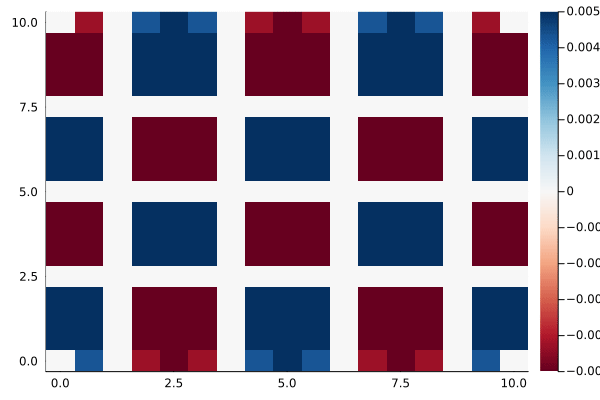

In [110]:
anim = @gif for k in 1:length(discrete_t)
    heatmap(discrete_x, discrete_y, sol_ϕ[:, :, k], clim=(-0.005, 0.005), cmap=:RdBu)
end

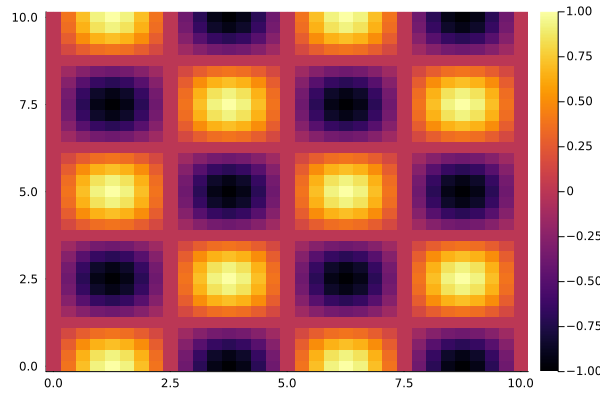

In [97]:
xx = ones(length(discrete_y)) * discrete_x'
yy = discrete_y * ones(length(discrete_x))'
heatmap(discrete_x, discrete_y, sin.(2π .* xx / 5) .* cos.(2π .* yy / 5))

33×33 Matrix{Float64}:
 0.0  0.3125  0.625  0.9375  1.25  …  8.75  9.0625  9.375  9.6875  10.0
 0.0  0.3125  0.625  0.9375  1.25     8.75  9.0625  9.375  9.6875  10.0
 0.0  0.3125  0.625  0.9375  1.25     8.75  9.0625  9.375  9.6875  10.0
 0.0  0.3125  0.625  0.9375  1.25     8.75  9.0625  9.375  9.6875  10.0
 0.0  0.3125  0.625  0.9375  1.25     8.75  9.0625  9.375  9.6875  10.0
 0.0  0.3125  0.625  0.9375  1.25  …  8.75  9.0625  9.375  9.6875  10.0
 0.0  0.3125  0.625  0.9375  1.25     8.75  9.0625  9.375  9.6875  10.0
 0.0  0.3125  0.625  0.9375  1.25     8.75  9.0625  9.375  9.6875  10.0
 0.0  0.3125  0.625  0.9375  1.25     8.75  9.0625  9.375  9.6875  10.0
 0.0  0.3125  0.625  0.9375  1.25     8.75  9.0625  9.375  9.6875  10.0
 0.0  0.3125  0.625  0.9375  1.25  …  8.75  9.0625  9.375  9.6875  10.0
 0.0  0.3125  0.625  0.9375  1.25     8.75  9.0625  9.375  9.6875  10.0
 0.0  0.3125  0.625  0.9375  1.25     8.75  9.0625  9.375  9.6875  10.0
 ⋮                                 ⋱     